## Binary classification using handcrafted features

In [14]:
import os
import cv2
import numpy as np
import joblib  # For caching features
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


In [3]:
DATASET_PATH = r"C:/datasets/Face-Mask-Detection--split-dataset" 
TRAIN_DATASET = f"{DATASET_PATH}/train"
TEST_DATASET = f"{DATASET_PATH}/test"
VALIDATION_DATASET = f"{DATASET_PATH}/val"
CATEGORIES = ["with_mask", "without_mask"]
FEATURES_FILE = "features.npy"
LABELS_FILE = "labels.npy"


In [4]:
def extract_features(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Local Binary Pattern
    lbp = local_binary_pattern(image_gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)

    # HOG Features
    hog_features = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

    return np.hstack([lbp_hist, hog_features]).astype(np.float32)  # Convert to float32 to save memory


In [78]:
def dataset_feature_extraction(datasetPath):
    print("Extracting features from images for ", datasetPath)
    X, y = [], []
    for label, category in enumerate(CATEGORIES):
        folder_path = os.path.join(datasetPath, category)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (128, 128))  # Resize for consistency
                features = extract_features(image)
                X.append(features)
                y.append(label)
            else:
                print(image_path, "is None")

    # Convert to NumPy and save for future use
    X = np.array(X)
    y = np.array(y)
    return X, y


In [80]:
# Check if precomputed features exist
if os.path.exists(FEATURES_FILE) and os.path.exists(LABELS_FILE):
    print("Loading precomputed features...")
    X = np.load(FEATURES_FILE)
    y = np.load(LABELS_FILE)
else:
    X, y = dataset_feature_extraction(TRAIN_DATASET)
    print("Saving features")
    np.save(FEATURES_FILE, X_train)
    np.save(LABELS_FILE, y_train)
    print("Saved")

X_train, y_train = X, y
print("Loaded test dataset from", TRAIN_DATASET)
X_test, y_test = dataset_feature_extraction(TEST_DATASET)
print("Loaded test dataset from", TEST_DATASET)
X_val, y_val = dataset_feature_extraction(VALIDATION_DATASET)
print("Loaded test dataset from", VALIDATION_DATASET)
# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loading precomputed features...
Loaded test dataset from C:/datasets/Face-Mask-Detection--split-dataset/train
Extracting features from images for  C:/datasets/Face-Mask-Detection--split-dataset/test
Loaded test dataset from C:/datasets/Face-Mask-Detection--split-dataset/test
Extracting features from images for  C:/datasets/Face-Mask-Detection--split-dataset/val
Loaded test dataset from C:/datasets/Face-Mask-Detection--split-dataset/val


In [81]:
print(len(y_val))

615


In [82]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Classification using SVM

In [20]:
model_filename = "svm_model.pkl"
want_training = False

if os.path.exists(model_filename) and not want_training:
    ## Load the model if it exists
    svm_clf = joblib.load(model_filename)
    print("Loaded existing SVM model.")
else:
    ## Train the model if it doesn't exist
    # svm_clf = SVC(kernel="linear")
    svm_clf = SVC(kernel="rbf")
    svm_clf.fit(X_train, y_train)
    joblib.dump(svm_clf, model_filename)
    print("Trained and saved a new SVM model.")
svm_preds = svm_clf.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))



Trained and saved a new SVM model.
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       325
           1       0.96      0.88      0.92       290

    accuracy                           0.93       615
   macro avg       0.93      0.92      0.92       615
weighted avg       0.93      0.93      0.92       615



array([[314,  11],
       [ 35, 255]], dtype=int64)

              precision    recall  f1-score   support

           0       0.53      1.00      0.69       320
           1       1.00      0.00      0.01       290

    accuracy                           0.53       610
   macro avg       0.76      0.50      0.35       610
weighted avg       0.75      0.53      0.36       610



<Axes: >

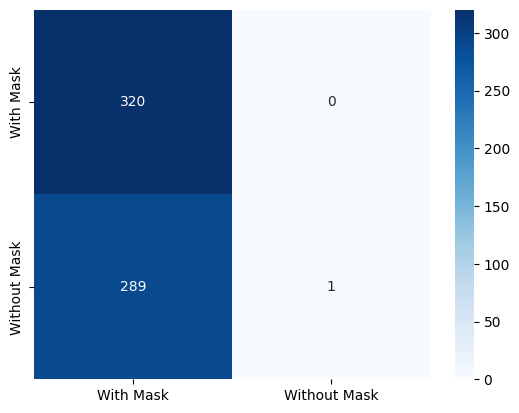

In [23]:
display(confusion_matrix(y_test, svm_preds))
conmat_svm = confusion_matrix(y_val, y_dash := svm_clf.predict(X_val))
print( classification_report(y_val, y_dash) )
labels = ['With Mask', 'Without Mask']
sns.heatmap(conmat_svm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)

total images are 615


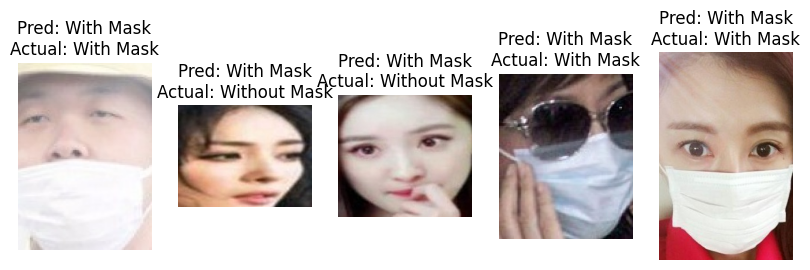

In [77]:
import random

labels = ["With Mask", "Without Mask"]
# Show random samples from test data
num_samples = 5
random_indices = random.sample(range(len(y_test)), num_samples)

plt.figure(figsize=(10, 5))
image_list = os.listdir(os.path.join(TEST_DATASET, CATEGORIES[0])) + os.listdir(os.path.join(TEST_DATASET, CATEGORIES[1]))
print("total images are", len(image_list))
for i, idx in enumerate(random_indices):
    # print(len(y_test), idx, y_test[idx], 
    #       len(image_list), len(image_list[0]), len(image_list[1]))
    img_path = os.path.join(TEST_DATASET, CATEGORIES[y_test[idx]], image_list[idx])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {labels[svm_preds[idx]]}\nActual: {labels[y_test[idx]]}")

plt.show()


### Classification using Neural Network

In [24]:
model_filename = "mlp_model.pkl"
want_training = False

if os.path.exists(model_filename) and not want_training:
    # Load the model if it exists
    mlp_clf = joblib.load(model_filename)
    print("Loaded existing MLP model.")
else:
    # Train the model if it doesn't exist
    mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam", max_iter=1000, random_state=42)
    mlp_clf.fit(X_train, y_train)
    joblib.dump(mlp_clf, model_filename)
    print("Trained and saved a new MLP model.")

mlp_preds = mlp_clf.predict(X_test)
print("Neural Network Classification Report:\n", classification_report(y_test, mlp_preds))


Loaded existing MLP model.
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       325
           1       0.95      0.91      0.93       290

    accuracy                           0.93       615
   macro avg       0.93      0.93      0.93       615
weighted avg       0.93      0.93      0.93       615



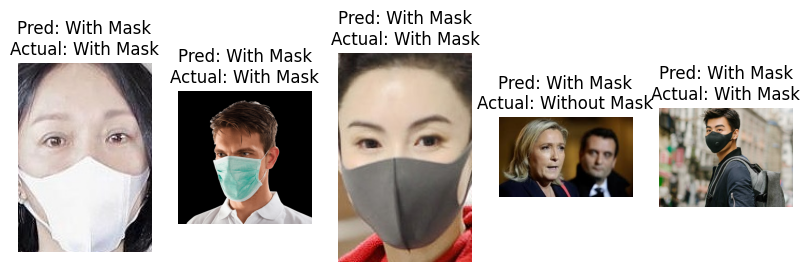

In [47]:
import random

labels = ["With Mask", "Without Mask"]
num_samples = 5
random_indices = random.sample(range(len(y_test)), num_samples)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    img_path = os.path.join(TEST_DATASET, CATEGORIES[y_test[idx]], image_list[idx])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {labels[mlp_preds[idx]]}\nActual: {labels[y_test[idx]]}")

plt.show()


array([[314,  11],
       [ 35, 255]], dtype=int64)

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       320
           1       0.94      0.70      0.80       290

    accuracy                           0.83       610
   macro avg       0.86      0.83      0.83       610
weighted avg       0.85      0.83      0.83       610



<Axes: >

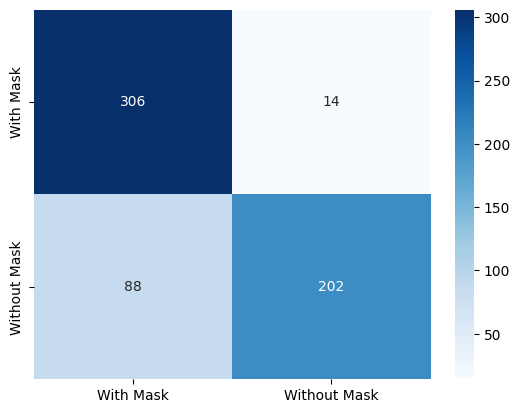

In [25]:
display(confusion_matrix(y_test, svm_preds))
conmat_mlp = confusion_matrix(y_val, y_dash := mlp_clf.predict(X_val))
print( classification_report(y_val, y_dash) )
labels = ['With Mask', 'Without Mask']
sns.heatmap(conmat_mlp, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)

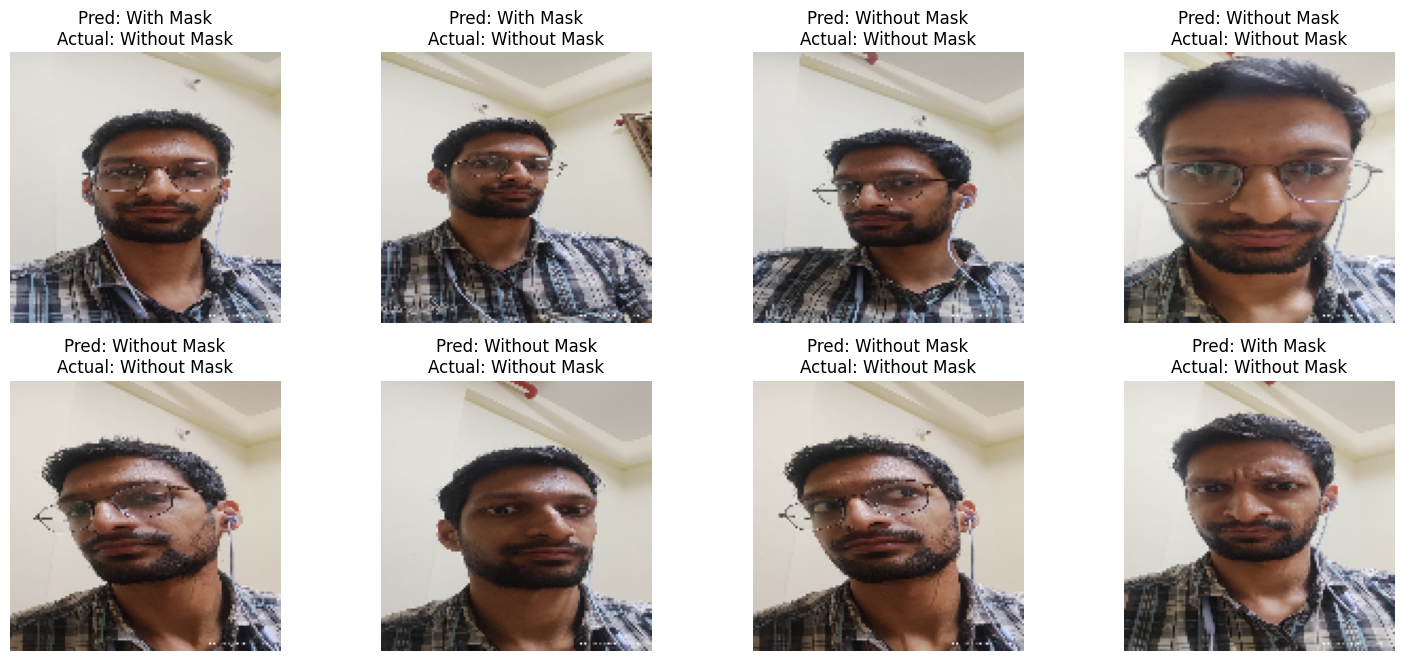

In [34]:
MASKLESS_IMAGES_PATH = "C:/datasets/Face-Mask-Detection/test-without_mask/"
labels = ["With Mask", "Without Mask"]

# Get all test image paths
image_paths = [os.path.join(MASKLESS_IMAGES_PATH, f) for f in os.listdir(MASKLESS_IMAGES_PATH)]
num_samples = len(image_paths)

# Extract features for all images in one step
images = [cv2.imread(img) for img in image_paths]
images = [cv2.resize(img, (128, 128)) for img in images if img is not None]
Xnew = np.array([extract_features(img) for img in images])
Xnew = scaler.transform(Xnew)  # Apply the same scaling as training

# Predict labels
ynew = svm_clf.predict(Xnew)

# Plot results
plt.figure(figsize=(min(15, 3 * num_samples), 10))
for idx, (img, pred) in enumerate(zip(images, ynew)):
    plt.subplot(3, num_samples//2, idx + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Pred: {labels[pred]}\nActual: Without Mask")

plt.tight_layout()
plt.savefig("svm_maskless_images_test.png")
plt.show()


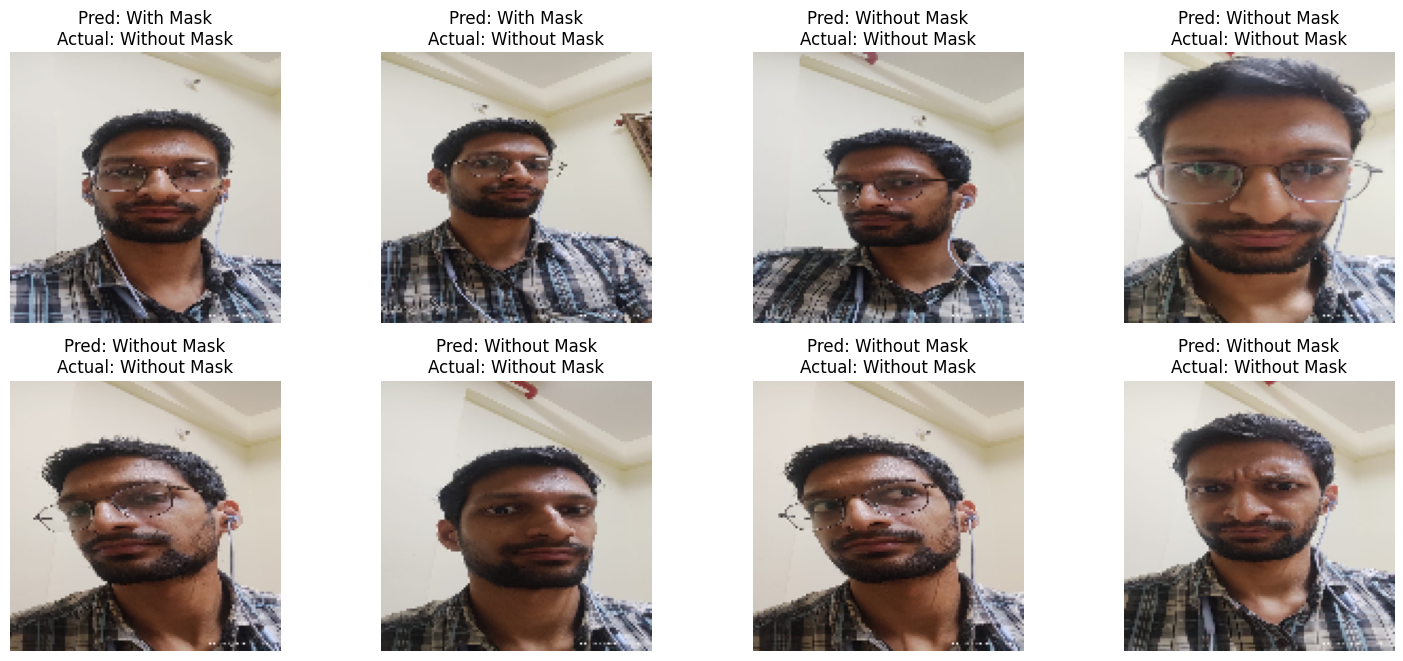

In [35]:
MASKLESS_IMAGES_PATH = "C:/datasets/Face-Mask-Detection/test-without_mask/"
labels = ["With Mask", "Without Mask"]

# Get all test image paths
image_paths = [os.path.join(MASKLESS_IMAGES_PATH, f) for f in os.listdir(MASKLESS_IMAGES_PATH)]
num_samples = len(image_paths)

# Extract features for all images in one step
images = [cv2.imread(img) for img in image_paths]
images = [cv2.resize(img, (128, 128)) for img in images if img is not None]
Xnew = np.array([extract_features(img) for img in images])
Xnew = scaler.transform(Xnew)  # Apply the same scaling as training

# Predict labels
ynew = mlp_clf.predict(Xnew)

# Plot results
plt.figure(figsize=(min(15, 3 * num_samples), 10))
for idx, (img, pred) in enumerate(zip(images, ynew)):
    plt.subplot(3, num_samples//2, idx + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Pred: {labels[pred]}\nActual: Without Mask")

plt.tight_layout()
plt.savefig("mlp_maskless_images_test.png")
plt.show()


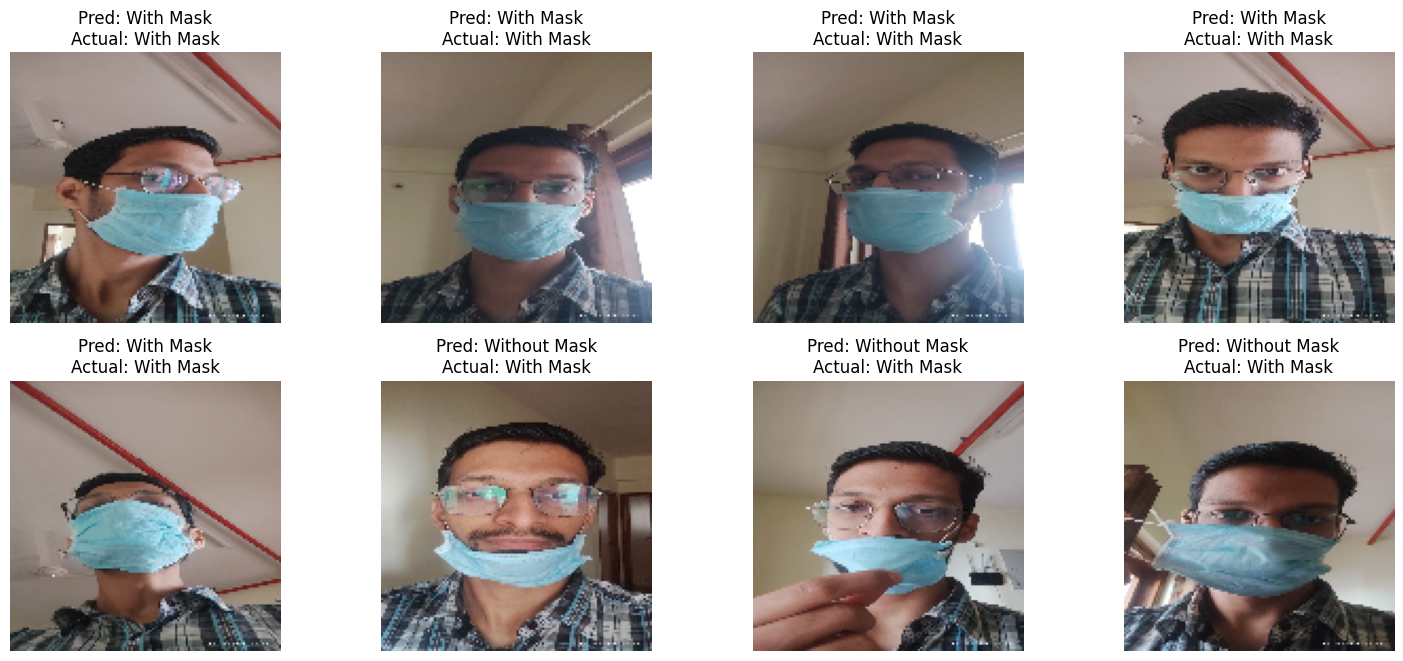

In [36]:
MASK_IMAGES_PATH = "C:/datasets/Face-Mask-Detection/test-with_mask/"
labels = ["With Mask", "Without Mask"]

# Get all test image paths
image_paths = [os.path.join(MASK_IMAGES_PATH, f) for f in os.listdir(MASK_IMAGES_PATH)]
num_samples = len(image_paths)

# Extract features for all images in one step
images = [cv2.imread(img) for img in image_paths]
images = [cv2.resize(img, (128, 128)) for img in images if img is not None]
Xnew = np.array([extract_features(img) for img in images])
Xnew = scaler.transform(Xnew)  # Apply the same scaling as training

# Predict labels
ynew = svm_clf.predict(Xnew)

# Plot results
plt.figure(figsize=(min(15, 3 * num_samples), 10))
for idx, (img, pred) in enumerate(zip(images, ynew)):
    plt.subplot(3, num_samples//2, idx + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Pred: {labels[pred]}\nActual: With Mask")

plt.tight_layout()
plt.savefig("svm_mask_images_test.png")
plt.show()


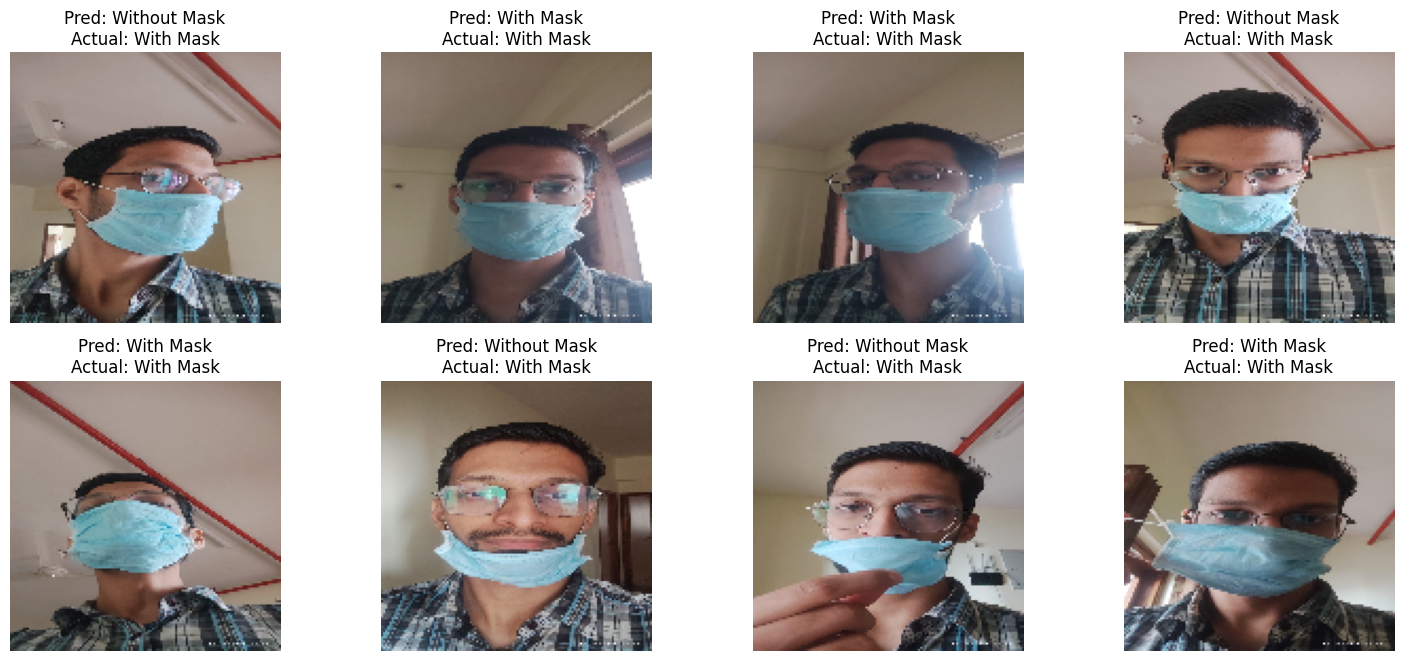

In [37]:
MASK_IMAGES_PATH = "C:/datasets/Face-Mask-Detection/test-with_mask/"
labels = ["With Mask", "Without Mask"]

# Get all test image paths
image_paths = [os.path.join(MASK_IMAGES_PATH, f) for f in os.listdir(MASK_IMAGES_PATH)]
num_samples = len(image_paths)

# Extract features for all images in one step
images = [cv2.imread(img) for img in image_paths]
images = [cv2.resize(img, (128, 128)) for img in images if img is not None]
Xnew = np.array([extract_features(img) for img in images])
Xnew = scaler.transform(Xnew)  # Apply the same scaling as training

# Predict labels
ynew = mlp_clf.predict(Xnew)

# Plot results
plt.figure(figsize=(min(15, 3 * num_samples), 10))
for idx, (img, pred) in enumerate(zip(images, ynew)):
    plt.subplot(3, num_samples//2, idx + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Pred: {labels[pred]}\nActual: With Mask")

plt.tight_layout()
plt.savefig("mlp_mask_images_test.png")
plt.show()


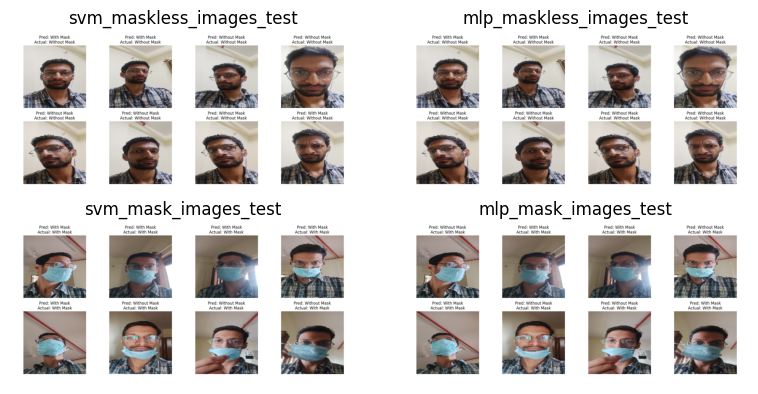

Saved image grid as svm_mlp_test_compare.png


In [51]:
import os
import matplotlib.pyplot as plt
import cv2

# Configuration: Set the image paths
image_paths = [
    "svm_maskless_images_test.png",
    "mlp_maskless_images_test.png",
    "svm_mask_images_test.png",
    "mlp_mask_images_test.png",
]

# Load images and extract filenames without extensions
images = []
titles = []
for img_path in image_paths:
    img = cv2.imread(img_path)  # Read image
    if img is None:
        print(f"Error: Unable to load {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    images.append(img)
    titles.append(os.path.splitext(os.path.basename(img_path))[0])

# Ensure we have exactly 4 images
if len(images) != 4:
    print("Error: Exactly 4 images are required.")
else:
    # Create a 2x2 subplot
    # fig, axes = plt.subplots(4, 1, figsize=(6, 8))
    fig, axes = plt.subplots(2, 2, figsize=(8, 4))
    # fig, axes = plt.subplots(4, 1, figsize=(10, 10))
    

    # Plot each image with its title
    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    # Adjust layout and save the figure
    plt.tight_layout()
    output_path = "svm_mlp_test_compare.png"
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"Saved image grid as {output_path}")


[[320   0]
 [289   1]]
[[306  14]
 [ 88 202]]
Saved plot of confusion matrix


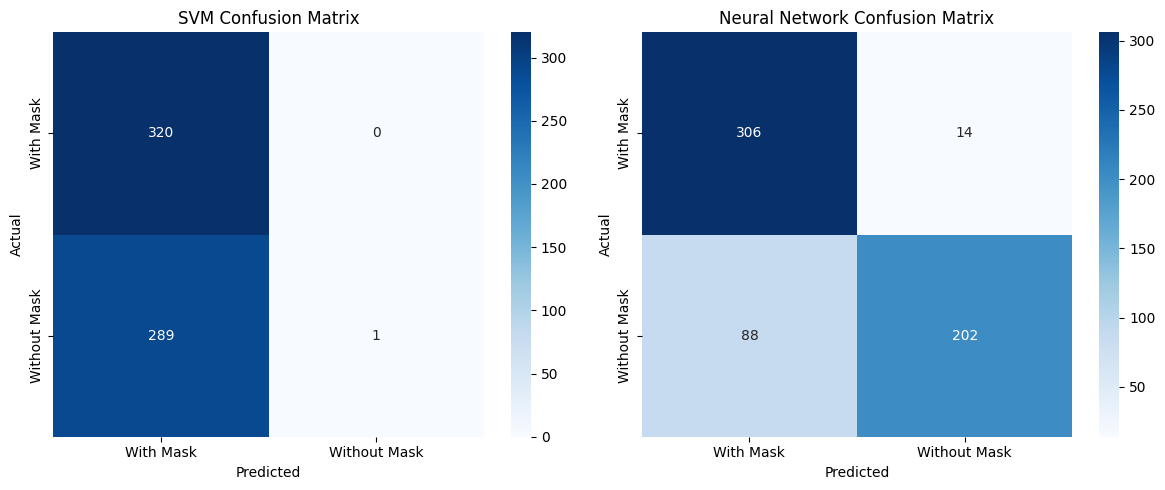

Saved plot of precision recall


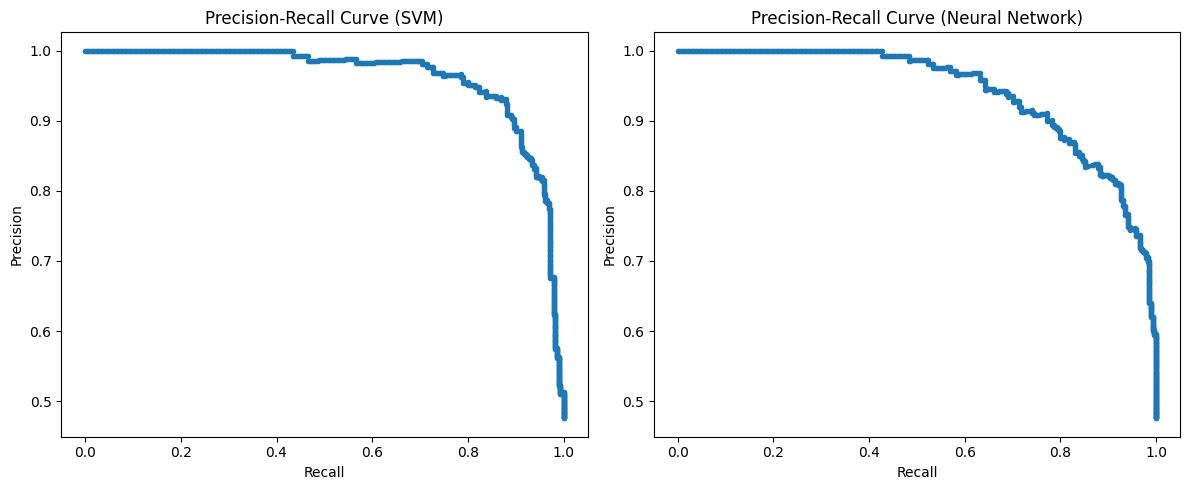

Saved plot of roc-aoc curve


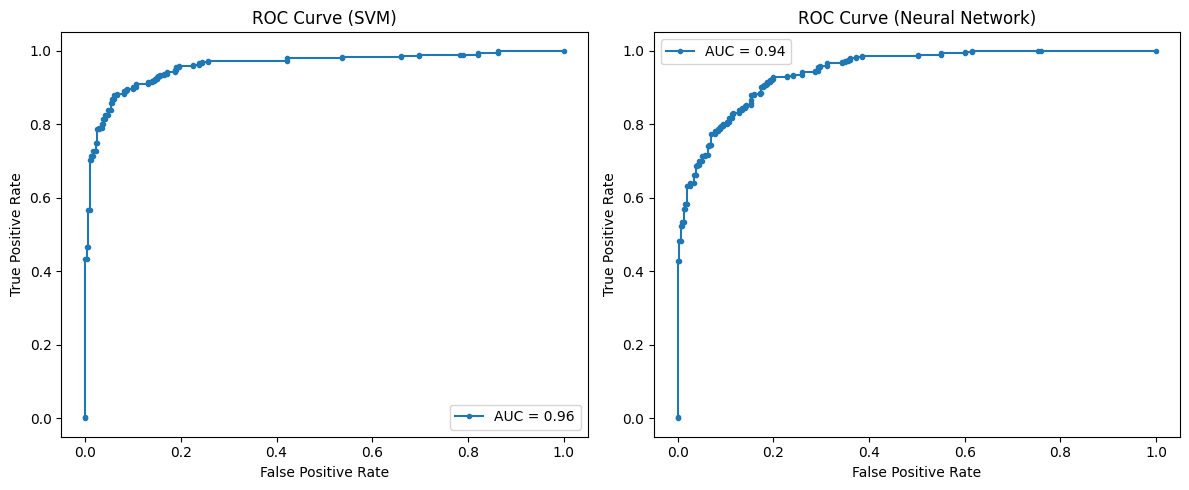

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, classification_report

# Labels for plotting (adjust as needed)
labels = ["With Mask", "Without Mask"]

# X_val, y_val = dataset_feature_extraction(VALIDATION_DATASET)

svm_preds = svm_clf.predict(X_val)
mlp_preds = mlp_clf.predict(X_val)

# ---------------------------------------------
# Confusion Matrices for SVM and Neural Network
# ---------------------------------------------
# Compute confusion matrices
cm_svm = confusion_matrix(y_val, svm_preds)
cm_mlp = confusion_matrix(y_val, mlp_preds)

print(cm_svm)
print(cm_mlp)

# Plot side by side confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title("SVM Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title("Neural Network Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.savefig('svm-mlp-confusion-matrix.png')
print("Saved plot of confusion matrix")
plt.show()

# -----------------------------------------------------
# Precision-Recall and ROC Curves for SVM and MLP Models
# -----------------------------------------------------
# --- For SVM ---
# For SVM, we use the decision_function for scoring.
precision_svm, recall_svm, _ = precision_recall_curve(y_val, svm_clf.decision_function(X_val))
fpr_svm, tpr_svm, _ = roc_curve(y_val, svm_clf.decision_function(X_val))
roc_auc_svm = auc(fpr_svm, tpr_svm)

# --- For Neural Network (MLP) ---
# For Neural Network, we get probability scores for the positive class.
mlp_probs = mlp_clf.predict_proba(X_val)[:, 1]
precision_mlp, recall_mlp, _ = precision_recall_curve(y_val, mlp_probs)
fpr_mlp, tpr_mlp, _ = roc_curve(y_val, mlp_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot Precision-Recall curves side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(recall_svm, precision_svm, marker=".")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve (SVM)")

axs[1].plot(recall_mlp, precision_mlp, marker=".")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].set_title("Precision-Recall Curve (Neural Network)")

plt.tight_layout()
plt.savefig('svm-mlp-precision-recall.png')
print("Saved plot of precision recall")
plt.show()

# Plot ROC curves side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(fpr_svm, tpr_svm, marker=".", label=f"AUC = {roc_auc_svm:.2f}")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].set_title("ROC Curve (SVM)")
axs[0].legend()

axs[1].plot(fpr_mlp, tpr_mlp, marker=".", label=f"AUC = {roc_auc_mlp:.2f}")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve (Neural Network)")
axs[1].legend()

plt.tight_layout()
plt.savefig('svm-mlp-roc.png')
print("Saved plot of roc-aoc curve")
plt.show()


In [87]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

# ------------------------------
# Print Classification Reports
# ------------------------------
report_svm = classification_report(y_val, svm_preds, output_dict=True)
df_svm = pd.DataFrame(report_svm).transpose()
report_mlp = classification_report(y_val, mlp_preds, output_dict=True)
df_mlp = pd.DataFrame(report_mlp).transpose()

display(df_svm)
display(df_mlp)


precision  recall  f1-score  support
0                  0.56    1.00      0.72   320.00
1                  1.00    0.13      0.24   290.00
accuracy           0.59    0.59      0.59     0.59
macro avg          0.78    0.57      0.48   610.00
weighted avg       0.77    0.59      0.49   610.00

precision  recall  f1-score  support
0                  0.78    0.96      0.86   320.00
1                  0.94    0.70      0.80   290.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.86    0.83      0.83   610.00
weighted avg       0.85    0.83      0.83   610.00

## Binary classification using CNN

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [54]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

transform = transforms.Compose([transforms.Resize((128,128),
                                interpolation = InterpolationMode.BILINEAR),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                                ])

In [84]:
dataset = r"C:/datasets/Face-Mask-Detection--split-dataset"

train_data = torchvision.datasets.ImageFolder(root=f"{dataset}/train", transform=transform)
val_data = torchvision.datasets.ImageFolder(root=f"{dataset}/val", transform=transform)
test_data = torchvision.datasets.ImageFolder(root=f"{dataset}/test", transform=transform)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# print(val_loader.dataset, test_loader)

In [85]:
class MaskCNN(nn.Module):
    def __init__(self):
        super(MaskCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x



### Train the model

In [ ]:
#  Initialize Model, Loss Function & Optimizer
model = MaskCNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#  Training Function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images, labels.float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images, labels.float().view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


In [ ]:
#  Train the Model
epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, epochs)

# Save the trained model
torch.save(model.state_dict(), "mask_detection_model_1.pth")
print("Model saved successfully.")

#  Plot Loss Curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


### Load and Test the model

In [57]:
model = MaskCNN()
# Load the saved weights into the model
model.load_state_dict(torch.load("mask_detection_model_1.pth"))

C:\Users\kusha\AppData\Local\Temp\ipykernel_11392\4027257687.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mask_detection_model_1.pth

<All keys matched successfully>

In [58]:
#  Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images
            outputs = model(images)
            predicted = (outputs.numpy() > 0.5).astype(int).flatten()
            predictions.extend(predicted)
            true_labels.extend(labels.numpy())

    # print(true_labels,predictions)

    acc = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Mask", "No Mask"], yticklabels=["Mask", "No Mask"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print(classification_report(true_labels, predictions, target_names=["Mask", "No Mask"]))

Test Accuracy: 0.9106


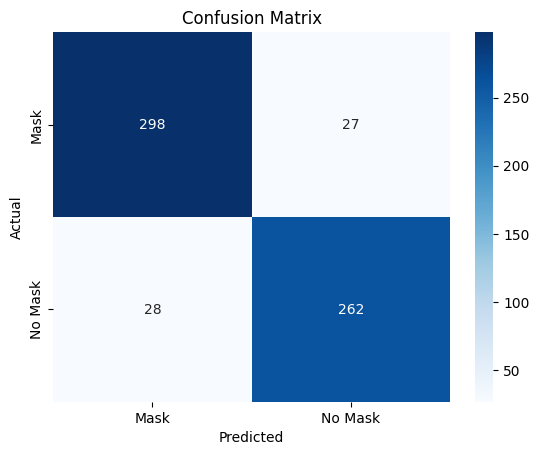

              precision    recall  f1-score   support

        Mask       0.91      0.92      0.92       325
     No Mask       0.91      0.90      0.91       290

    accuracy                           0.91       615
   macro avg       0.91      0.91      0.91       615
weighted avg       0.91      0.91      0.91       615



In [59]:
evaluate_model(model, val_loader)

In [86]:
import torch.nn.functional as F

# ---------------------------
# 3. Compute CNN Predictions and Confidence Scores
# ---------------------------
cnn_preds = []
cnn_probs = []  # For the positive class (assumed to be index 1)
all_y_test = []  # To ensure order of labels matches predictions

model.eval()
# predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images
        outputs = model(images)
        predicted = (outputs.numpy() > 0.5).astype(int).flatten()
        cnn_preds.extend(predicted)
        cnn_probs.extend(outputs.cpu().numpy().flatten())    
        true_labels.extend(labels.numpy())

ycnn_val = true_labels
# with torch.no_grad():
#     for images, labels in val_loader:
#         # images = images.to(device)
#         outputs = model(images)  # Raw logits
#         probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
#         _, predicted = torch.max(outputs, 1)
#         cnn_preds.extend(predicted.cpu().numpy())
#         cnn_probs.extend(probs.cpu().numpy().flatten())
#         all_y_test.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
cnn_preds = np.array(cnn_preds)
cnn_probs = np.array(cnn_probs)

# If your test labels (y_test) for SVM and MLP come from a different source,
# ensure they match the order in the test dataset for CNN. Here we assume they are the same.
# Otherwise, you might use:
# y_test = np.array(all_y_test)



In [73]:
print(cnn_preds.shape, y_val.shape, len(val_loader)
     )

(615,) (610,) 20


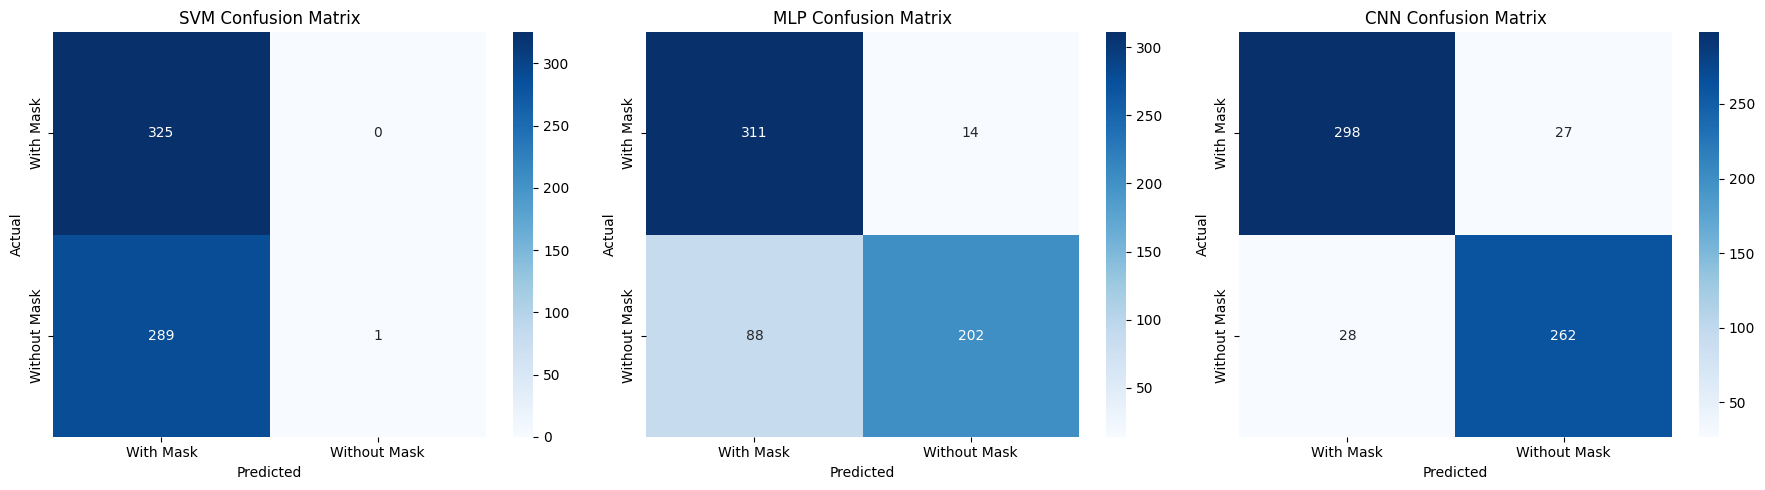

In [87]:
# ---------------------------
# 4. Comparison: Confusion Matrices (SVM, MLP, CNN)
# ---------------------------
labels_names = ["With Mask", "Without Mask"]

svm_preds = svm_clf.predict(X_val)
mlp_preds = mlp_clf.predict(X_val)

# Compute confusion matrices for each model (svm_preds and mlp_preds assumed pre-computed)
cm_svm = confusion_matrix(y_val, svm_preds)
cm_mlp = confusion_matrix(y_val, mlp_preds)
cm_cnn = confusion_matrix(ycnn_val, cnn_preds)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels_names, yticklabels=labels_names, ax=axs[0])
axs[0].set_title("SVM Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels_names, yticklabels=labels_names, ax=axs[1])
axs[1].set_title("MLP Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels_names, yticklabels=labels_names, ax=axs[2])
axs[2].set_title("CNN Confusion Matrix")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()



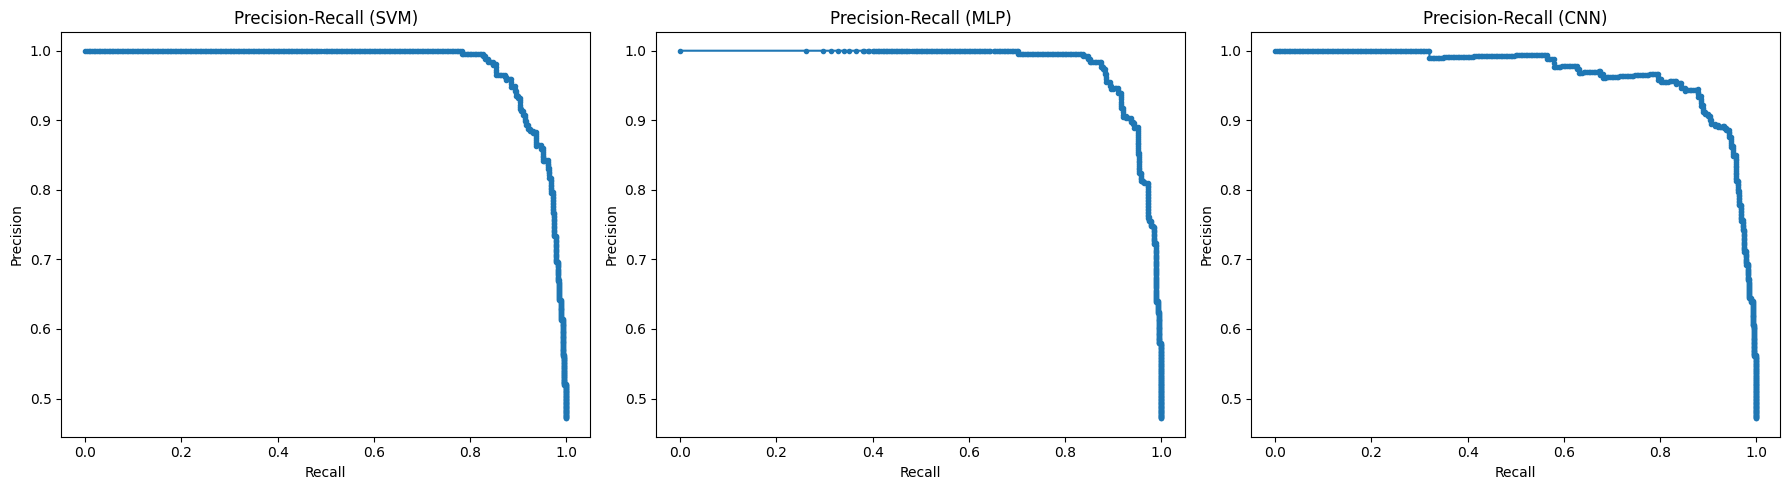

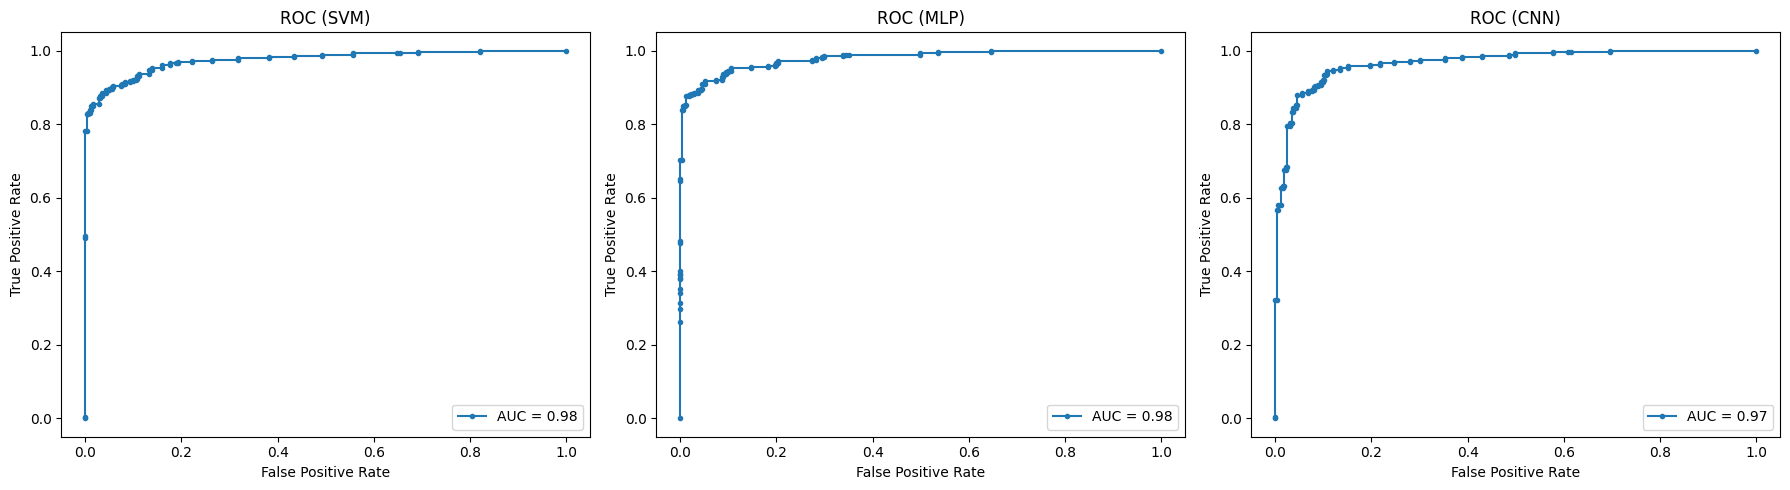

In [88]:
# ---------------------------
# 5. Comparison: Precision-Recall and ROC Curves
# ---------------------------
# --- SVM: using decision_function ---
precision_svm, recall_svm, _ = precision_recall_curve(y_val, svm_clf.decision_function(X_test))
fpr_svm, tpr_svm, _ = roc_curve(y_val, svm_clf.decision_function(X_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)

# --- MLP: using predict_proba ---
mlp_probs = mlp_clf.predict_proba(X_test)[:, 1]
precision_mlp, recall_mlp, _ = precision_recall_curve(y_val, mlp_probs)
fpr_mlp, tpr_mlp, _ = roc_curve(y_val, mlp_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# --- CNN: using cnn_probs computed above ---
precision_cnn, recall_cnn, _ = precision_recall_curve(ycnn_val, cnn_probs)
fpr_cnn, tpr_cnn, _ = roc_curve(ycnn_val, cnn_probs)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Plot Precision-Recall Curves side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(recall_svm, precision_svm, marker=".")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall (SVM)")

axs[1].plot(recall_mlp, precision_mlp, marker=".")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].set_title("Precision-Recall (MLP)")

axs[2].plot(recall_cnn, precision_cnn, marker=".")
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].set_title("Precision-Recall (CNN)")

plt.tight_layout()
plt.show()

# Plot ROC Curves side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(fpr_svm, tpr_svm, marker=".", label=f"AUC = {roc_auc_svm:.2f}")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].set_title("ROC (SVM)")
axs[0].legend()

axs[1].plot(fpr_mlp, tpr_mlp, marker=".", label=f"AUC = {roc_auc_mlp:.2f}")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC (MLP)")
axs[1].legend()

axs[2].plot(fpr_cnn, tpr_cnn, marker=".", label=f"AUC = {roc_auc_cnn:.2f}")
axs[2].set_xlabel("False Positive Rate")
axs[2].set_ylabel("True Positive Rate")
axs[2].set_title("ROC (CNN)")
axs[2].legend()

plt.tight_layout()
plt.show()



Indices where MLP fails but CNN succeeds: [  1  71 137 163 228 237 258 315 327 329 330 337 338 339 340 341 343 344
 345 346 351 352 354 355 356 360 361 362 363 365 369 370 380 384 385 388
 389 390 397 398 399 400 402 404 407 414 426 429 433 442 458 465 466 479
 481 488 494 496 497 503 505 506 508 510 512 513 517 524 526 535 549 556
 566 570 573 580 588 597 607 612 613]
Indices where CNN fails but MLP succeeds: [  0  21  27 124 138 147 157 168 172 205 212 213 215 216 217 219 226 242
 269 294 324 411 419 422 425 473 500 509 533 557 563 593 600 610]


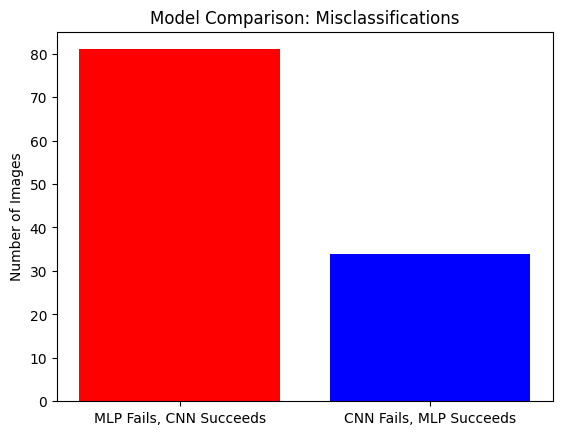

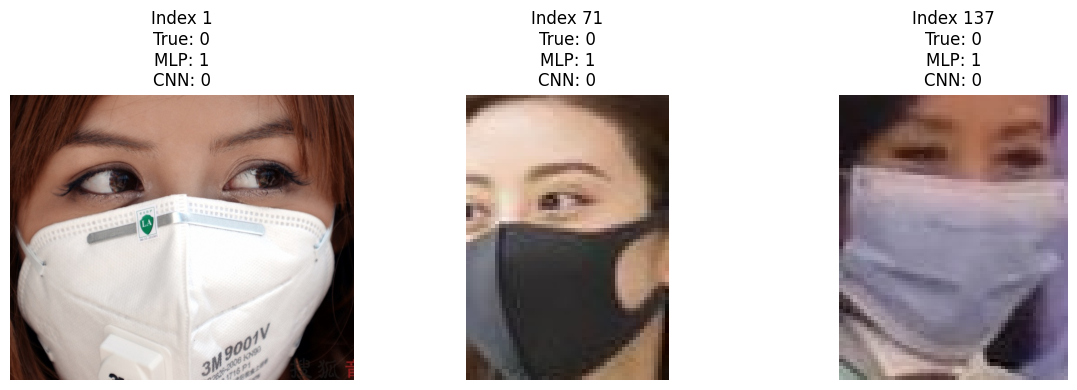

In [91]:
# ---------------------------
# 6. Error Analysis: Where MLP Fails but CNN Succeeds and Vice Versa
# ---------------------------
import numpy as np

# Indices where predictions differ from true labels
mlp_wrong = np.where(mlp_preds != y_val)[0]
cnn_correct = np.where(cnn_preds == y_val)[0]
mlp_fail_cnn_success = np.intersect1d(mlp_wrong, cnn_correct)

cnn_wrong = np.where(cnn_preds != ycnn_val)[0]
mlp_correct = np.where(mlp_preds == y_val)[0]
cnn_fail_mlp_success = np.intersect1d(cnn_wrong, mlp_correct)

print("Indices where MLP fails but CNN succeeds:", mlp_fail_cnn_success)
print("Indices where CNN fails but MLP succeeds:", cnn_fail_mlp_success)

labels = ['MLP Fails, CNN Succeeds', 'CNN Fails, MLP Succeeds']
values = [len(mlp_fail_cnn_success), len(cnn_fail_mlp_success)]

plt.bar(labels, values, color=['red', 'blue'])
plt.ylabel('Number of Images')
plt.title('Model Comparison: Misclassifications')
plt.show()


# (Optional) Visualize a few error cases if dealing with images
# For example, display 3 images from mlp_fail_cnn_success:
if len(mlp_fail_cnn_success) > 0:
    fig, axs = plt.subplots(1, min(3, len(mlp_fail_cnn_success)), figsize=(12, 4))
    for i, idx in enumerate(mlp_fail_cnn_success[:3]):
        img_path, _ = test_data.samples[idx]
        img = plt.imread(img_path)
        axs[i].imshow(img)
        axs[i].set_title(f"Index {idx}\nTrue: {y_val[idx]}\nMLP: {mlp_preds[idx]}\nCNN: {cnn_preds[idx]}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()



SVM Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69       325
           1       1.00      0.00      0.01       290

    accuracy                           0.53       615
   macro avg       0.76      0.50      0.35       615
weighted avg       0.75      0.53      0.37       615

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86       325
           1       0.94      0.70      0.80       290

    accuracy                           0.83       615
   macro avg       0.86      0.83      0.83       615
weighted avg       0.85      0.83      0.83       615

CNN Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       325
           1       0.91      0.90      0.91       290

    accuracy                           0.91       615
   macro avg       0.91      0.91      0.91 

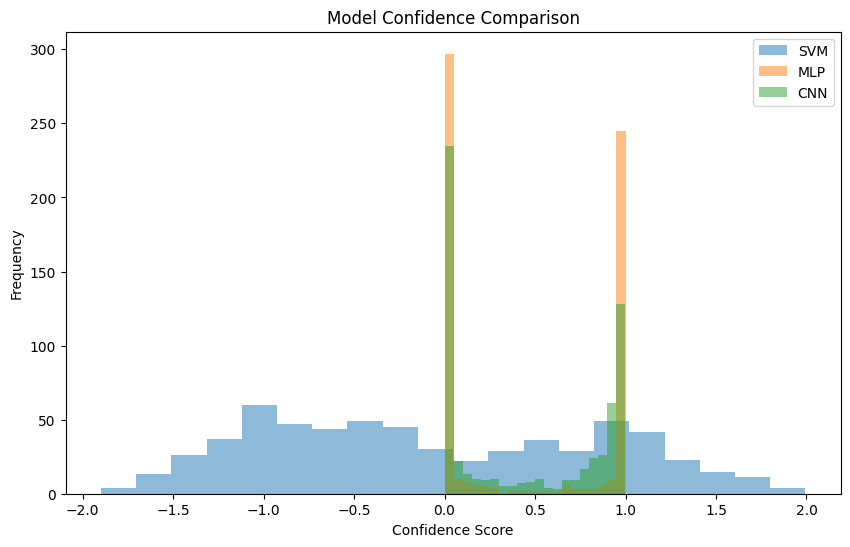

In [90]:
# ---------------------------
# 7. Classification Reports for All Models
# ---------------------------
print("SVM Classification Report:\n", classification_report(y_val, svm_preds))
print("MLP Classification Report:\n", classification_report(y_val, mlp_preds))
print("CNN Classification Report:\n", classification_report(y_val, cnn_preds))

# ---------------------------
# 8. Model Confidence Comparison (Histogram of Confidence Scores)
# ---------------------------
# For SVM, use decision_function scores (note: they can be negative, so consider absolute or proper interpretation)
svm_confidences = svm_clf.decision_function(X_test)
# For MLP, we already computed mlp_probs for the positive class
# For CNN, we already have cnn_probs

plt.figure(figsize=(10, 6))
plt.hist(svm_confidences, bins=20, alpha=0.5, label="SVM")
plt.hist(mlp_probs, bins=20, alpha=0.5, label="MLP")
plt.hist(cnn_probs, bins=20, alpha=0.5, label="CNN")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Model Confidence Comparison")
plt.legend()
plt.show()
